In [57]:
import numpy as np
import pandas as pd
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [58]:
data = scipy.io.loadmat('./part_1.mat')
print("Keys in the mat file:", data.keys())

Keys in the mat file: dict_keys(['__header__', '__version__', '__globals__', 'p'])


In [59]:
test_sample = scipy.io.loadmat(f'./part_{1}.mat')['p']
print(f'test_sample Data type: {type(test_sample)}')
print(f'test_sample shape/dimensions: {test_sample.shape}')
#print(test_sample)
#print(test_sample[0][1])
print(len(test_sample))
print(len(test_sample[0]))
inner = test_sample[0][1][0]
print(inner)
print(len(inner))
print(len(test_sample[0][1]))

test_sample Data type: <class 'numpy.ndarray'>
test_sample shape/dimensions: (1, 1000)
1
1000
[2.40957967 2.32942326 2.23851417 ... 1.24046921 1.23069404 1.21994135]
61000
3


In [60]:
sample_size = 125 

ppg_all = []
ecg_all = []
bp_all = []
sbp_all = []
dbp_all = []

for i in range(1, 6) : # part 1 ~ 5 
    file_path = f'./part_{i}.mat'
    
    try:
        data = scipy.io.loadmat(file_path)
        
        if 'p' in data:
            mat_data = data['p']
            print(f"Loaded {file_path} successfully. Shape: {mat_data.shape}")
            
            for j in range(len(mat_data[0])):
                temp_mat = mat_data[0, j]
                temp_length = temp_mat.shape[1]
                
                for k in range(int(temp_length/sample_size)):
                    temp_ppg = temp_mat[0, k*sample_size:(k+1)*sample_size]
                    temp_ecg = temp_mat[2, k*sample_size:(k+1)*sample_size]
                    temp_bp = temp_mat[1, k*sample_size:(k+1)*sample_size]
                    
                    max_value = max(temp_bp)  # SBP
                    min_value = min(temp_bp)  # DBP
                    
                    ppg_all.append(temp_ppg)
                    ecg_all.append(temp_ecg)
                    bp_all.append(temp_bp)
                    sbp_all.append(max_value)
                    dbp_all.append(min_value)
        else:
            exit()
            
    except Exception as e:
        print (e)
        
ppg_all = np.array(ppg_all)
ecg_all = np.array(ecg_all)
bp_all = np.array(bp_all)
sbp_all = np.array(sbp_all).reshape(-1, 1)
dbp_all = np.array(dbp_all).reshape(-1, 1)

bp_combined = np.zeros((sbp_all.shape[0], 2))
bp_combined[:, 0] = sbp_all[:, 0]
bp_combined[:, 1] = dbp_all[:, 0]

print(f"Total number of samples: {len(ppg_all)}")
print(f"PPG signal shape: {ppg_all.shape}")
print(f"BP combined shape: {bp_combined.shape}")

Loaded ./part_1.mat successfully. Shape: (1, 1000)
Loaded ./part_2.mat successfully. Shape: (1, 1000)
Loaded ./part_3.mat successfully. Shape: (1, 1000)
Loaded ./part_4.mat successfully. Shape: (1, 1000)
could not read bytes
Total number of samples: 907624
PPG signal shape: (907624, 125)
BP combined shape: (907624, 2)


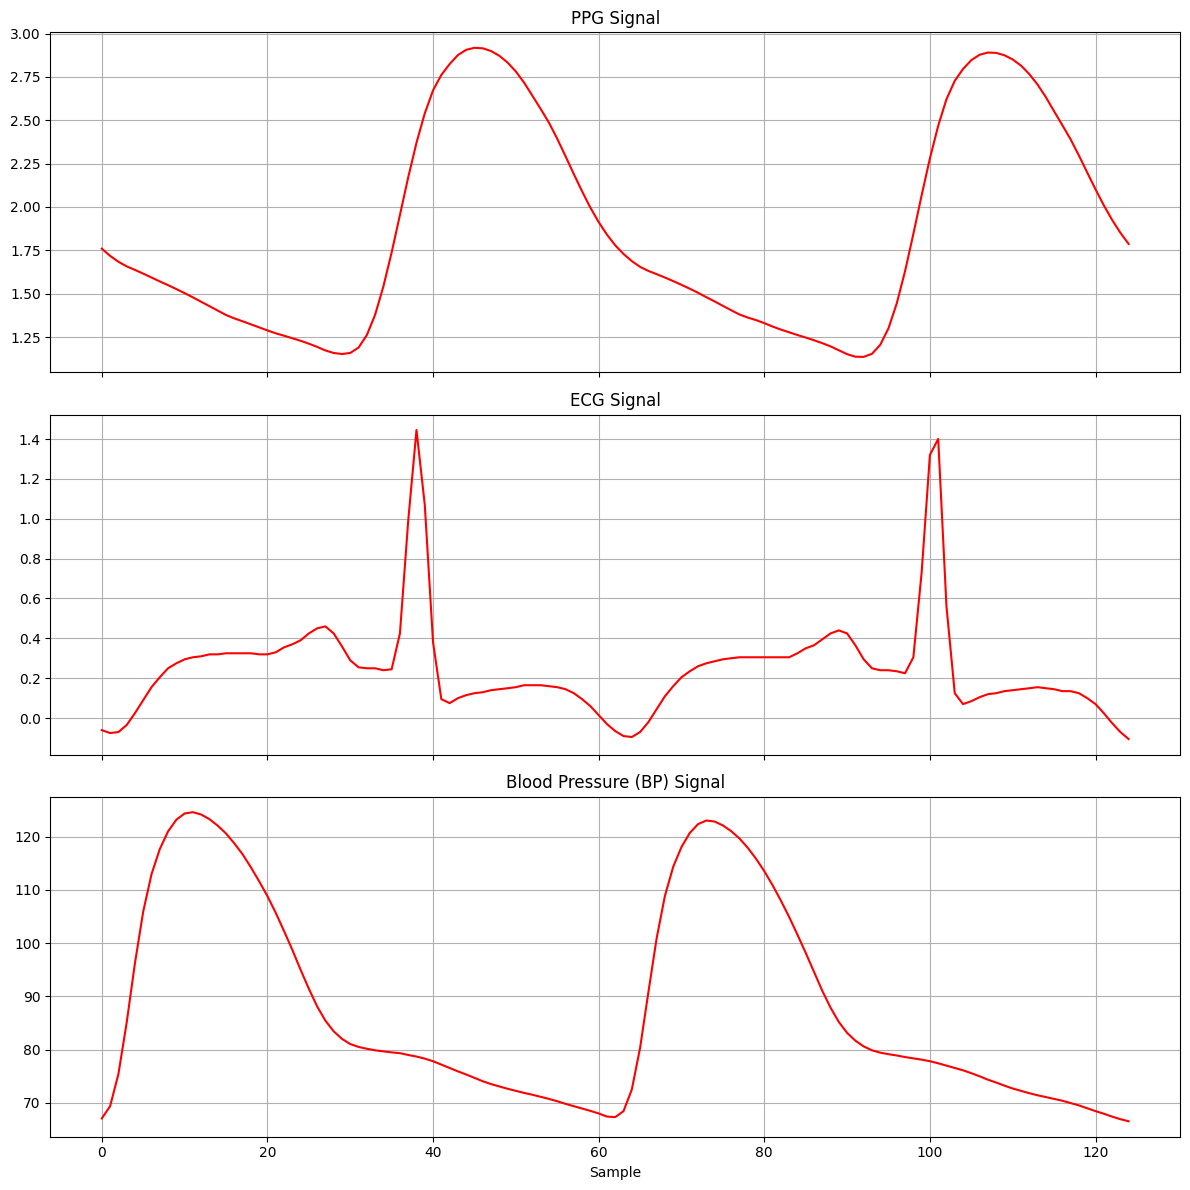

In [61]:
# Cell 3: Visualize some samples
fig, ax = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

ax[0].set_title('PPG Signal')
ax[0].plot(ppg_all[0, :], 'r-')
ax[0].grid(True)

ax[1].set_title('ECG Signal')
ax[1].plot(ecg_all[0, :], 'r-')
ax[1].grid(True)

ax[2].set_title('Blood Pressure (BP) Signal')
ax[2].set_xlabel('Sample')
ax[2].plot(bp_all[0, :], 'r-')
ax[2].grid(True)

plt.tight_layout()
plt.show()

In [62]:
class RevIN(nn.Module):
    def __init__(self, num_features):
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.running_mean = None
        self.running_var = None
        
    def forward(self, x, mode='norm'):
        # x shape: [Batch, Channel, Time]
        if mode == 'norm':
            self.running_mean = x.mean(dim=2, keepdim=True)
            self.running_var = x.var(dim=2, keepdim=True)
            x_normalized = (x - self.running_mean) / (self.running_var + 1e-5).sqrt()
            return x_normalized
        elif mode == 'denorm':
            return x * (self.running_var + 1e-5).sqrt() + self.running_mean

In [63]:
class PatchTST(nn.Module):
    def __init__(self, c_in, seq_len, patch_len, stride, d_model, nhead, num_layers, 
                 dropout=0.1, fc_dropout=0.2, output_dim=2):
        super(PatchTST, self).__init__()
        
        # Model parameters
        self.seq_len = seq_len
        self.patch_len = patch_len
        self.stride = stride
        self.num_patches = (seq_len - patch_len) // stride + 1
        self.c_in = c_in
        
        # Normalization layer
        self.revin = RevIN(c_in)
        
        # Patch embedding
        self.patch_embedding = nn.Linear(patch_len, d_model)
        
        # Position encoding
        self.position_encoding = nn.Parameter(torch.randn(1, self.num_patches, d_model))
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dropout=dropout,
            dim_feedforward=4*d_model,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc_dropout = nn.Dropout(fc_dropout)
        self.projection = nn.Linear(d_model * self.num_patches, output_dim)
        
    def forward(self, x):
        # x shape: [Batch, Time, Channel]
        
        # Change dimensions [Batch, Time, Channel] -> [Batch, Channel, Time]
        x = x.permute(0, 2, 1)
        
        # RevIN normalization
        x = self.revin(x, 'norm')
        
        # Prepare for channel-independent processing
        batch_size, channels, seq_len = x.shape
        
        # Create patches
        # [Batch, Channel, Time] -> [Batch*Channel, num_patches, patch_len]
        x_patched = torch.zeros((batch_size*channels, self.num_patches, self.patch_len), 
                               device=x.device)
        
        for i in range(self.num_patches):
            start_idx = i * self.stride
            end_idx = start_idx + self.patch_len
            x_patched[:, i, :] = x.reshape(batch_size*channels, seq_len)[:, start_idx:end_idx]
        
        # Patch embedding
        # [Batch*Channel, num_patches, patch_len] -> [Batch*Channel, num_patches, d_model]
        x_embedded = self.patch_embedding(x_patched)
        
        # Add position encoding
        x_embedded = x_embedded + self.position_encoding
        
        # Apply dropout
        x_embedded = self.dropout(x_embedded)
        
        # Pass through Transformer encoder
        x_transformed = self.transformer_encoder(x_embedded)
        
        # Flatten
        # [Batch*Channel, num_patches, d_model] -> [Batch*Channel, num_patches*d_model]
        x_flat = self.flatten(x_transformed)
        x_flat = self.fc_dropout(x_flat)
        
        # Channel-wise prediction
        # [Batch*Channel, num_patches*d_model] -> [Batch*Channel, output_dim]
        x_out = self.projection(x_flat)
        
        # Restore original batch dimension
        # [Batch*Channel, output_dim] -> [Batch, Channel, output_dim]
        x_out = x_out.reshape(batch_size, channels, -1)
        
        # Adjust output shape
        # [Batch, Channel, output_dim] -> [Batch, output_dim]
        x_out = x_out.mean(dim=1)  # Channel mean
        
        return x_out

In [64]:
ppg_with_channel = ppg_all.reshape(ppg_all.shape[0], ppg_all.shape[1], 1)
print(f"PPG with channel shape: {ppg_with_channel.shape}")

X_train, X_test, y_train, y_test = train_test_split(ppg_with_channel, bp_combined, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print(f"Training data shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Validation data shapes: X={X_val.shape}, y={y_val.shape}")
print(f"Test data shapes: X={X_test.shape}, y={y_test.shape}")

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

PPG with channel shape: (907624, 125, 1)
Training data shapes: X=(544574, 125, 1), y=(544574, 2)
Validation data shapes: X=(181525, 125, 1), y=(181525, 2)
Test data shapes: X=(181525, 125, 1), y=(181525, 2)


In [65]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train_scaled)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val_scaled)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test_scaled)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [66]:
c_in = 1  # # of input channels (PPG only)
seq_len = sample_size  # 125 as per the reference code
patch_len = 5  # Length of each patch
patch_stride = 2  # Stride between patches
d_model = 64  # Embedding dimension
nhead = 4  # Number of attention heads
num_layers = 3  # Number of transformer layers
dropout = 0.1
fc_dropout = 0.3
output_dim = 2  # SBP and DBP

In [67]:
# from torchsummary import summary
from torchinfo import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = PatchTST(
    c_in=c_in,
    seq_len=seq_len,
    patch_len=patch_len,
    stride=patch_stride,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dropout=dropout,
    fc_dropout=fc_dropout,
    output_dim=output_dim
).to(device)

print(model)

Using device: cuda
PatchTST(
  (revin): RevIN()
  (patch_embedding): Linear(in_features=5, out_features=64, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_dropout): Dropout(p=0.3, inplace=False)
  (projection): Linear(in_features=

In [68]:
from torchinfo import summary

model_summary = summary(
    model, 
    input_size=(batch_size, seq_len, 1),  # (batch_size, sequence_length, input_channels)
    col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
    verbose=2
)

print(model_summary)
# summary(model, input_size=(1, seq_len), batch_size=batch_size)

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
PatchTST                                      [64, 125, 1]              [64, 2]                   3,904                     --                        --
├─position_encoding                                                                               └─3,904                   [1, 61, 64]
├─RevIN: 1-1                                  [64, 1, 125]              [64, 1, 125]              --                        --                        --
├─Linear: 1-2                                 [64, 61, 5]               [64, 61, 64]              384                       --                        24,576
│    └─weight                                                                                     ├─320                     [5, 64]
│    └─bias                                                                                       └─64       

In [69]:
from tqdm.auto import tqdm
import time

def train_model(model, train_loader, val_loader, epochs=50, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Disable verbose in scheduler to avoid warnings
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=False
    )
    
    history = {
        'train_loss': [],
        'val_loss': []
    }
    
    best_val_loss = float('inf')
    
    # Main progress bar for epochs
    epoch_bar = tqdm(range(epochs), desc="Training Progress", unit="epoch")
    
    for epoch in epoch_bar:
        # Training phase
        model.train()
        train_loss = 0.0
        batch_count = 0
        
        # Start time for epoch
        start_time = time.time()
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.requires_grad_(True)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            batch_count += 1
            
            if batch_count % 10 == 0:
                avg_loss = train_loss / batch_count
                epoch_bar.set_postfix({
                    "epoch": f"{epoch+1}/{epochs}",
                    "phase": "train",
                    "loss": f"{avg_loss:.4f}"
                })
        
        train_loss /= len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        
        # Update learning rate
        scheduler.step(val_loss)
        curr_lr = scheduler.optimizer.param_groups[0]['lr']
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_patchtst_bp_model.pth')
        
        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        # Calculate epoch time
        epoch_time = time.time() - start_time
        
        # Update epoch progress bar with summary
        epoch_bar.set_postfix({
            "epoch": f"{epoch+1}/{epochs}",
            "train_loss": f"{train_loss:.4f}",
            "val_loss": f"{val_loss:.4f}",
            "lr": f"{curr_lr:.6f}",
            "time": f"{epoch_time:.1f}s"
        })
    
    return history

In [70]:
epochs = 100
learning_rate = 0.001

history = train_model(
    model,
    train_loader,
    val_loader,
    epochs=epochs,
    lr=learning_rate
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training Progress:   0%|          | 0/100 [00:00<?, ?epoch/s]

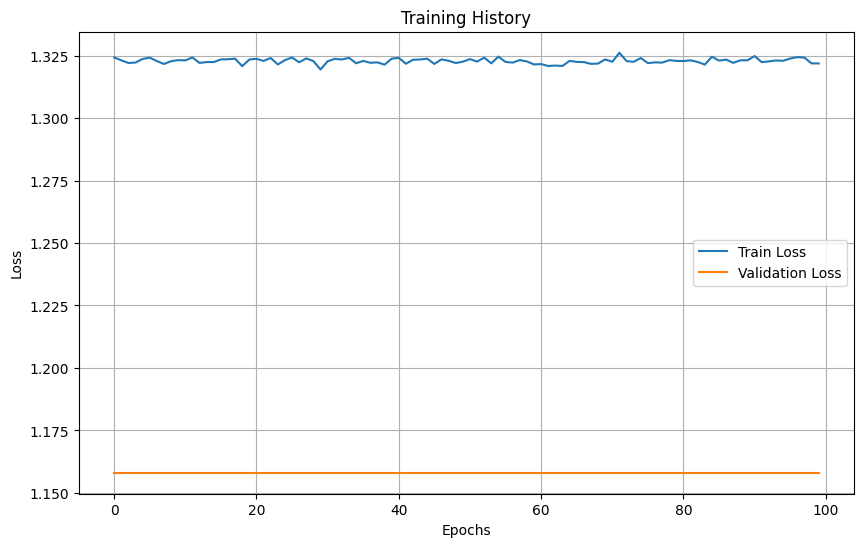

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

In [72]:
model.load_state_dict(torch.load('best_patchtst_bp_model.pth'))
model.eval()

y_pred_scaled = []
y_true_scaled = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        
        y_pred_scaled.extend(outputs.cpu().numpy())
        y_true_scaled.extend(targets.cpu().numpy())

y_pred_scaled = np.array(y_pred_scaled)
y_true_scaled = np.array(y_true_scaled)

y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_true_scaled)

sbp_true = y_true[:, 0]
dbp_true = y_true[:, 1]
sbp_pred = y_pred[:, 0]
dbp_pred = y_pred[:, 1]

sbp_mae = mean_absolute_error(sbp_true, sbp_pred)
sbp_mse = mean_squared_error(sbp_true, sbp_pred)
sbp_rmse = np.sqrt(sbp_mse)

dbp_mae = mean_absolute_error(dbp_true, dbp_pred)
dbp_mse = mean_squared_error(dbp_true, dbp_pred)
dbp_rmse = np.sqrt(dbp_mse)

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print("Systolic Blood Pressure (SBP) Metrics:")
print(f"MAE: {sbp_mae:.4f}")
print(f"MSE: {sbp_mse:.4f}")
print(f"RMSE: {sbp_rmse:.4f}")
print("\nDiastolic Blood Pressure (DBP) Metrics:")
print(f"MAE: {dbp_mae:.4f}")
print(f"MSE: {dbp_mse:.4f}")
print(f"RMSE: {dbp_rmse:.4f}")
print("\nOverall Metrics:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

/tmp/ipykernel_788/638144778.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_patchtst_bp_model.pth'))


Systolic Blood Pressure (SBP) Metrics:
MAE: 20.4904
MSE: 607.3843
RMSE: 24.6452

Diastolic Blood Pressure (DBP) Metrics:
MAE: 8.9070
MSE: 156.7992
RMSE: 12.5219

Overall Metrics:
MAE: 14.6987
MSE: 382.0760
RMSE: 19.5468


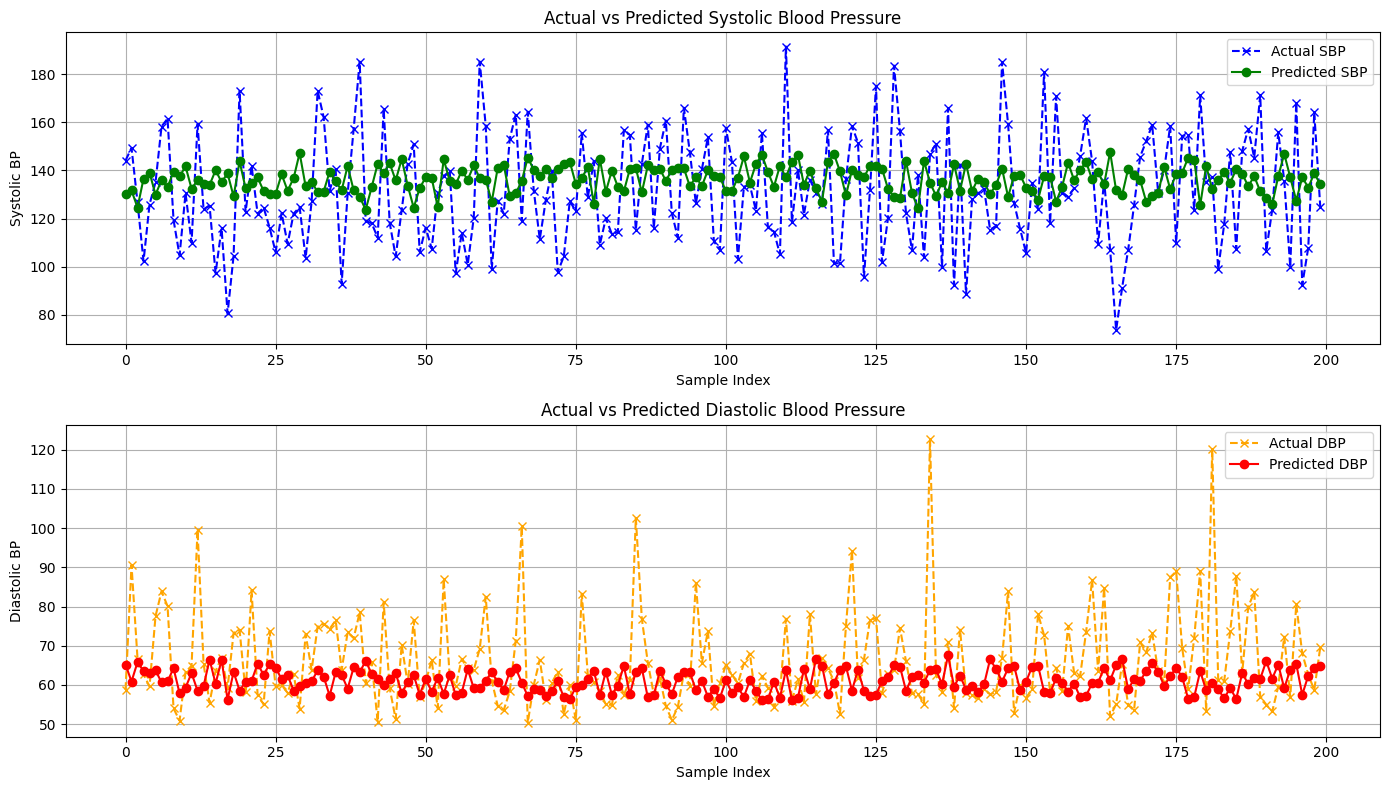

In [73]:
sample_indices = np.arange(len(sbp_true))
samples_to_show = 200

plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(sample_indices[:samples_to_show], sbp_true[:samples_to_show], marker='x', linestyle='--', color='blue', label='Actual SBP')
plt.plot(sample_indices[:samples_to_show], sbp_pred[:samples_to_show], marker='o', linestyle='-', color='green', label='Predicted SBP')
plt.xlabel('Sample Index')
plt.ylabel('Systolic BP')
plt.title('Actual vs Predicted Systolic Blood Pressure')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(sample_indices[:samples_to_show], dbp_true[:samples_to_show], marker='x', linestyle='--', color='orange', label='Actual DBP')
plt.plot(sample_indices[:samples_to_show], dbp_pred[:samples_to_show], marker='o', linestyle='-', color='red', label='Predicted DBP')
plt.xlabel('Sample Index')
plt.ylabel('Diastolic BP')
plt.title('Actual vs Predicted Diastolic Blood Pressure')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

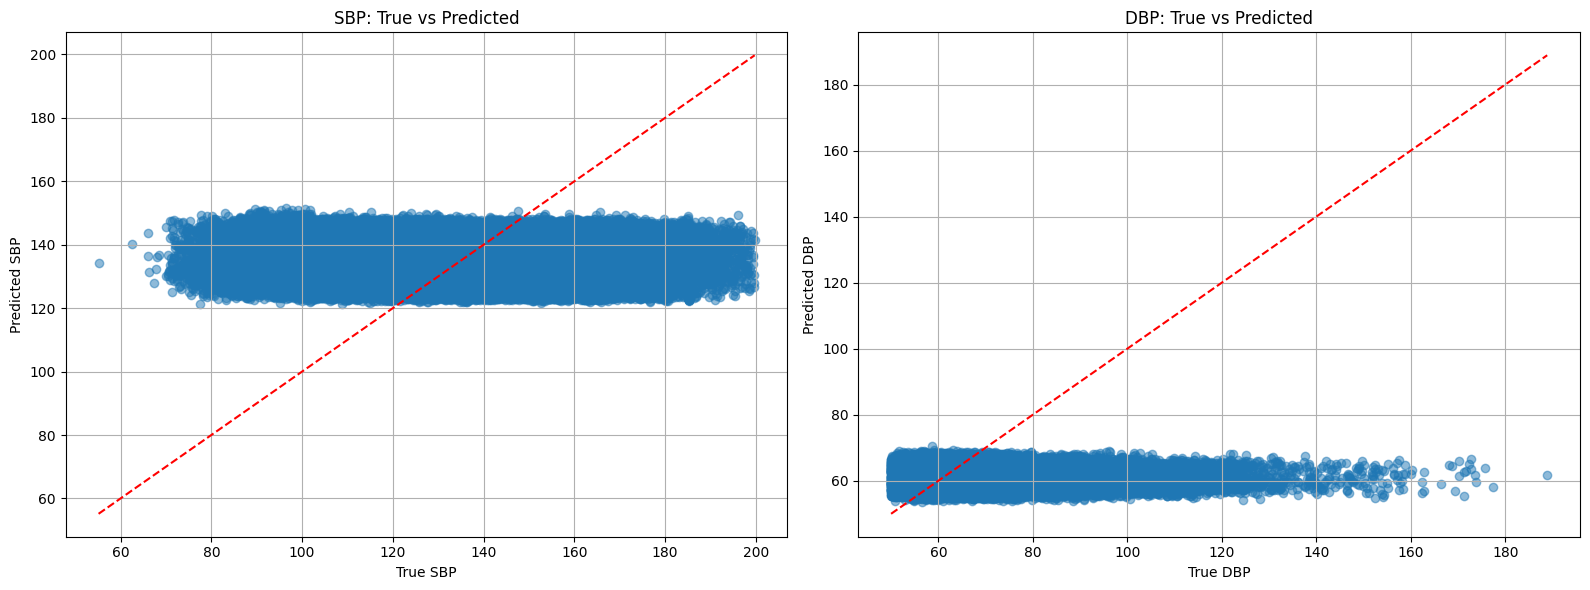

In [74]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.scatter(sbp_true, sbp_pred, alpha=0.5)
plt.plot([min(sbp_true), max(sbp_true)], [min(sbp_true), max(sbp_true)], 'r--')
plt.xlabel('True SBP')
plt.ylabel('Predicted SBP')
plt.title('SBP: True vs Predicted')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(dbp_true, dbp_pred, alpha=0.5)
plt.plot([min(dbp_true), max(dbp_true)], [min(dbp_true), max(dbp_true)], 'r--')
plt.xlabel('True DBP')
plt.ylabel('Predicted DBP')
plt.title('DBP: True vs Predicted')
plt.grid(True)

plt.tight_layout()
plt.show()